In [29]:
library(Mfuzz)
library(dplyr)
library(tidyr)
library(ggplot2)

In [30]:
expressionMatrix <- read.table("./Homoeolog_expression.txt", header = T, row.names = 1)
head(expressionMatrix)

,A2_4DPA,A2_8DPA,A2_12DPA,A2_16DPA,A2_20DPA,B1_4DPA,B1_8DPA,B1_12DPA,B1_16DPA,B1_20DPA,type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Garb_01G030000-Gano_01G000040,0.6452,0.6139,0.6660,0.5231,0.4685,1.190047,1.413454,1.567879,2.028546,1.069145,A2_B1
Garb_01G029990-Gano_01G000050,10.7459,9.2693,6.8339,8.7349,5.7195,6.156795,6.970914,7.648766,8.473101,10.631173,A2_B1
Garb_01G029980-Gano_01G000060,0.5580,0.3503,0.0977,0.1368,0.0000,0.120997,0.587220,0.132894,0.454345,0.047560,A2_B1
Garb_01G029970-Gano_01G000070,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,NoneExpression
Garb_01G029960-Gano_01G000080,11.6406,6.7617,2.0908,2.8603,2.3288,24.061975,25.348438,8.248104,10.218884,8.566041,A2_B1
Garb_01G029950-Gano_01G000090,14.6362,13.4244,7.3266,8.5282,9.4618,29.569347,22.388542,28.071423,25.468292,25.715939,A2_B1


In [31]:
#* A2 expression matrix
A2expressionData <- expressionMatrix %>%
    filter(type %in% c("A2_B1", "A2expression")) %>%
    select(starts_with("A2"))

#* B1 expression matrix
B1expressionData <- expressionMatrix %>%
    filter(type %in% c("A2_B1", "B1expression")) %>%
    select(starts_with("B1"))

In [6]:
#-----------------------------------------------
#* Mfuzz cluste
#-----------------------------------------------
dat <- dat <- new("ExpressionSet", exprs = as.matrix(A2expressionData))
dat.r <- filter.NA(dat, thres = 0.1)
# 2. replace remaining missing values
dat.f <- fill.NA(dat.r, mode = "mean")
# !3. 将不同的基因标准化到欧几里得空间，比较表达模式的相关性
dat.s <- standardise(dat.f)
m1 <- mestimate(dat.s)
m1

0 genes excluded.


[1] 1.991511

,c:3,c:6,c:9,c:12,c:15,c:18
repeats:1,3,6,9,12,15,18
repeats:2,3,6,9,12,14,18
repeats:3,3,6,9,12,15,17
repeats:4,3,6,9,12,15,18
repeats:5,3,6,9,12,14,17


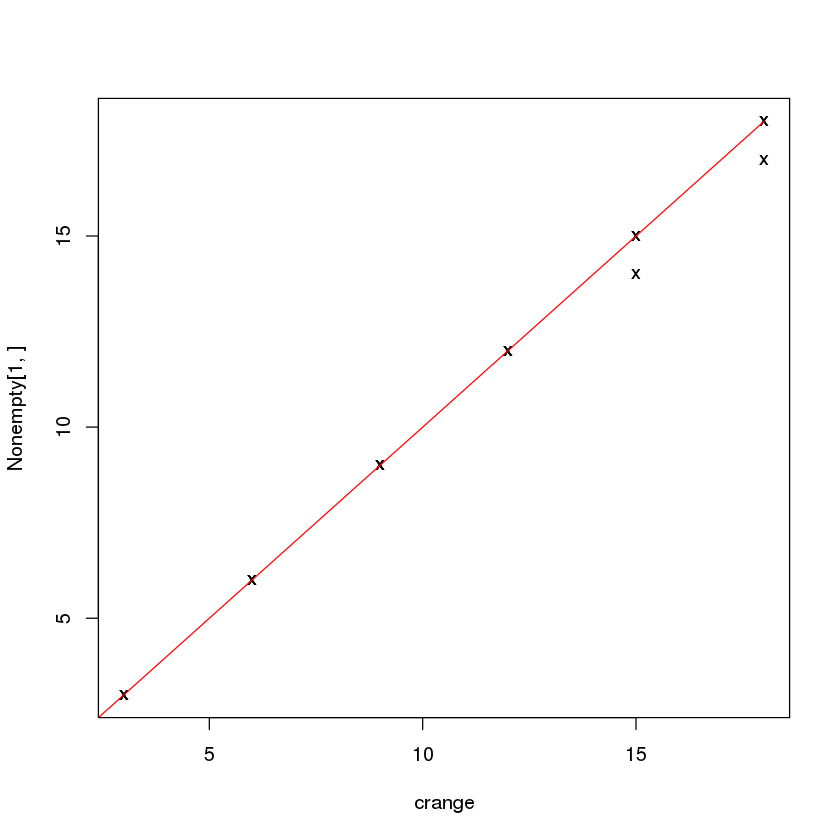

In [20]:
#!4. 估计超参数(聚类的数目C)
#* 可以看到在指定20类的时候回出现空的cluster
cselection(dat.s, m = m1, crange = seq(3, 20, 3), repeats = 5, visu = T)

[1] 0.7958058 0.7891891 0.7793647 0.6488318 0.6682665 0.5065221 0.5333708
 [8] 0.5576854 0.4700358 0.4245973 0.4432660

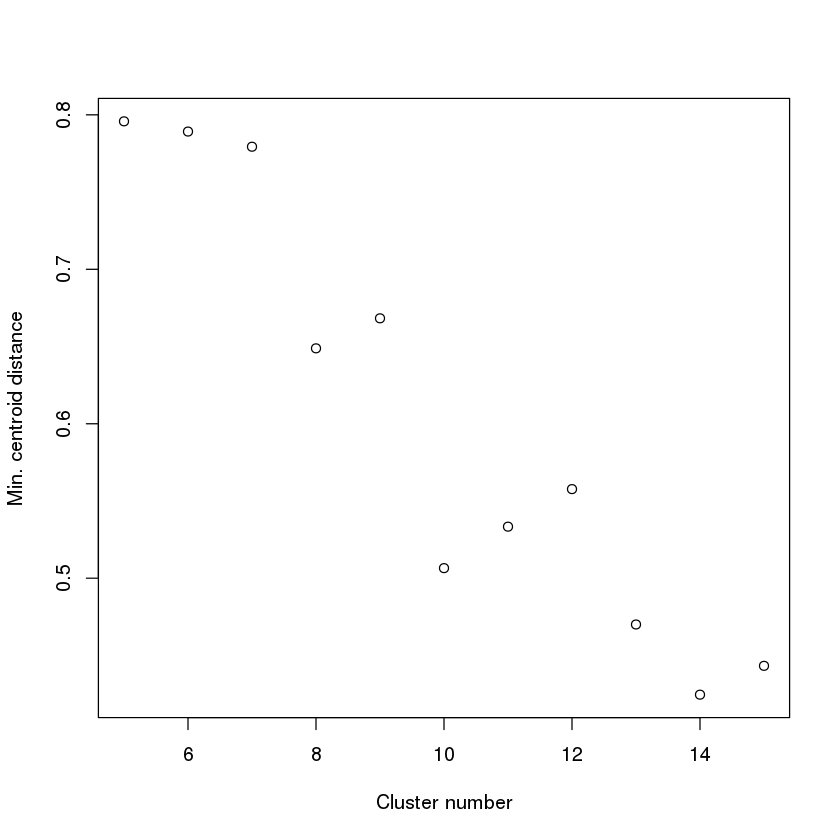

In [21]:
#* 确定最小的分类数目
Dmin(dat.s, m = m1, crange = seq(5, 15, 1), repeats = 3, visu = T)

In [7]:
#* 从Dmin得出分类数为10类
cl2 <- mfuzz(dat.s,c=10,m=m1)

In [16]:
centersData=as.data.frame(cl2$centers)
write.table(centersData,'A2_cluster_center.txt',row.names=T,sep="\t",quote = F)

In [17]:
#----------------------------------------------------------------------
# ! 绘制pattern
#----------------------------------------------------------------------
scale_expression <- t(as.data.frame(dat.s))
rownames(scale_expression)=gsub('\\.','-',rownames(scale_expression))
scale_expression=as.data.frame(scale_expression)
sampleClust <- as.data.frame(cl2$cluster)
#* gene ID
scale_expression$geneId=rownames(scale_expression)
#*cluster Id
scale_expression$cluster=sampleClust[,1]
#* membeership 
scale_expression$membership=apply(cl2$membership,1,max)
# scale_expression=read.table("A2_10_cluster.txt",header = T,row.names = 1)
plotData <- scale_expression %>% pivot_longer(
    cols = ends_with("DPA"),
    names_to = "stage",
    values_to = "scale_size"
)
plotData$geneId=as.factor(plotData$geneId)
plotData$stage <-factor(plotData$stage,levels=c('A2_4DPA','A2_8DPA','A2_12DPA','A2_16DPA','A2_20DPA'))

In [18]:
write.table(scale_expression, "A2_10_cluster.txt", row.names = T, col.names = T, sep = "\t",quote = FALSE)

png 
  2

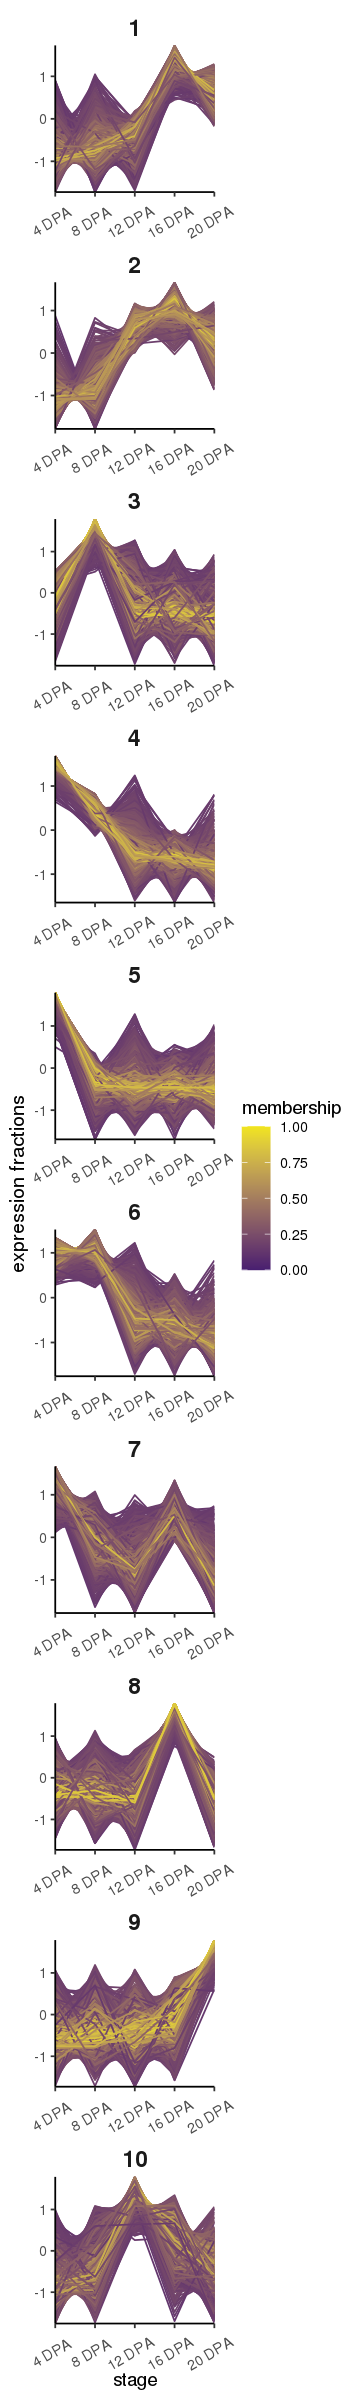

In [19]:
#----------------------------------
#TODO plotData 
#----------------------------------
library(ggplot2)
options(repr.plot.width = 3, repr.plot.height = 20)
p=ggplot(plotData, aes(
    x = stage,
    y = scale_size,
    group = geneId,
    color = membership,
)) +
    geom_line() +
    theme_classic() +
    theme(
        panel.background = element_blank(),
        panel.grid = element_blank(),
        axis.title.y = element_text(size = 12),
        axis.text.x = element_text(angle = 30, vjust = 0.5, hjust = 0.6),
        strip.background = element_blank(),
        strip.text = element_text(size = 14, face = "bold")
    ) +
    scale_y_continuous( expand = c(0, 0)) +
    scale_x_discrete(
        expand = c(0, 0),
        labels = c("4 DPA", "8 DPA", "12 DPA", "16 DPA", "20 DPA")
    ) +
    ylab("expression fractions") +
    scale_color_gradient(
        low = "#481f70",
        high = "#f1e51d",
        space = "Lab",
        na.value = "grey50",
        guide = "colourbar",
        n.breaks = 5, # ! 分成多少块
        limits = c(0, 1) # ! breaks的范围，默认是数据的范围
    ) +
    facet_wrap(~cluster, scales = "free",nrow = 10 )
# png("A2_cluster.png",width = 50,height = 450)
# print(p)
# dev.off()
p

In [32]:
#------------------------------------------------
#* 分析A2中每个cluster基因在B1中的pattern
#------------------------------------------------
scale_expression=read.table("A2_10_cluster.txt",header = T,row.names = 1)
cluster1_B1=B1expressionData[rownames(scale_expression %>% filter(cluster==8)),]
#* 同源基因在另外一个亚组中没有表达，会出现NA

dim(cluster1_B1)

[1] 1713    5

In [82]:
#--------------------------------------------
# TODO:过滤E1与A1的表达
#--------------------------------------------
cluster1_B1 <- read.table("E1_cluster/A2_cluster10_expression.txt", header = T, row.names = 1, sep = "\t")
cluster1_B1 <- cluster1_B1 %>%
    filter(type == "expression") %>%
    select(ends_with("DPA"))

In [83]:
dat <- dat <- new("ExpressionSet", exprs = as.matrix(cluster1_B1))
dat.r <- filter.NA(dat, thres = 0.1)
# 2. replace remaining missing values
dat.f <- fill.NA(dat.r, mode = "mean")
# !3. 将不同的基因标准化到欧几里得空间，比较表达模式的相关性
dat.s <- standardise(dat.f)
m1 <- mestimate(dat.s)
options(repr.plot.width = 3, repr.plot.height = 3)
# Dmin(dat.s, m = m1, crange = seq(5, 12, 1), repeats = 3, visu = T)
cl2 <- mfuzz(dat.s,c=6,m=m1)


0 genes excluded.


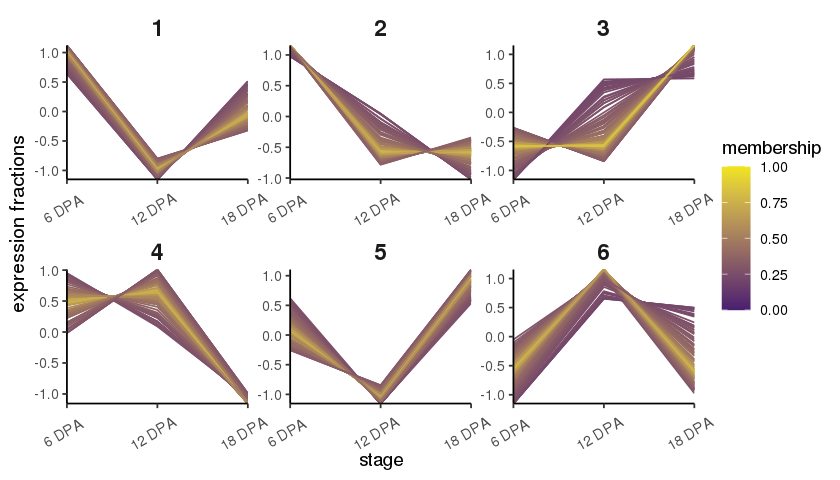

In [84]:
scale_expression2 <- t(as.data.frame(dat.s))
rownames(scale_expression2)=gsub('\\.','-',rownames(scale_expression2))
scale_expression2=as.data.frame(scale_expression2)
sampleClust <- as.data.frame(cl2$cluster)
#* gene ID
scale_expression2$geneId=rownames(scale_expression2)
#*cluster Id
scale_expression2$cluster=sampleClust[,1]
#* membeership 
scale_expression2$membership=apply(cl2$membership,1,max)

centersData=as.data.frame(cl2$centers)
write.table(centersData,'E1_cluster/A2_cluster10_center.txt',row.names=T,sep="\t",quote = F)
write.table(scale_expression2, "E1_cluster/A2_cluster10_scale.txt", row.names = T, col.names = T, sep = "\t",quote = FALSE)


plotData <- scale_expression2 %>% pivot_longer(
    cols = ends_with("DPA"),
    names_to = "stage",
    values_to = "scale_size"
)
plotData$geneId=as.factor(plotData$geneId)
plotData$stage <-factor(plotData$stage,levels=c('E1_6DPA','E1_12DPA','A1_16DPA'))
# plotData$stage <-factor(plotData$stage,levels=c('B1_4DPA','B1_8DPA','B1_12DPA','B1_16DPA','B1_20DPA'))

options(repr.plot.width = 7, repr.plot.height = 4)
ggplot(plotData, aes(
    x = stage,
    y = scale_size,
    group = geneId,
    color = membership,
)) +
    geom_line() +
    theme_classic() +
    theme(
        panel.background = element_blank(),
        panel.grid = element_blank(),
        axis.title.y = element_text(size = 12),
        axis.text.x = element_text(angle = 30, vjust = 0.5, hjust = 0.6),
        strip.background = element_blank(),
        strip.text = element_text(size = 14, face = "bold")
    ) +
    scale_y_continuous( expand = c(0, 0)) +
    scale_x_discrete(
        expand = c(0, 0),
        labels = c("6 DPA", "12 DPA", "18 DPA")
    ) +
    ylab("expression fractions") +
    scale_color_gradient(
        low = "#481f70",
        high = "#f1e51d",
        space = "Lab",
        na.value = "grey50",
        guide = "colourbar",
        n.breaks = 5, # ! 分成多少块
        limits = c(0, 1) # ! breaks的范围，默认是数据的范围
    ) +
    facet_wrap(~cluster, scales = "free",nrow = 2)

In [231]:
#----------------------------------------------------------------------
#* 以A2为reference，计算每类中对应的同源基因在B1中分成3类
#? 欧式距离最接近的
#? 欧式距离中间
#? 欧式距离最远的
#----------------------------------------------------------------------
cluster1_B1=B1expressionData[rownames(scale_expression %>% filter(cluster==10)),]
B1_test=cluster1_B1 %>% filter(B1_4DPA!='NA')
write.table(A2expressionData[rownames(B1_test),],'A2_test.txt',sep="\t",quote = FALSE,row.names = T,col.names = T)
write.table(B1_test,'B1_test.txt',sep="\t",quote = FALSE,row.names = T,col.names = T)

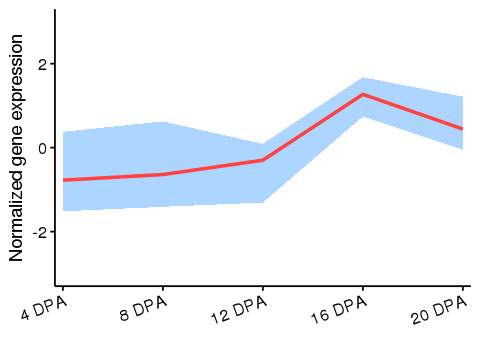

In [5]:
library(ggplot2)
plotData=read.table("./plots/A2_cluster1/A2_cluster1.txt",header=T,sep="\t",row.names=1)
plotData$stage=rownames(plotData)
plotData$stage=factor(plotData$stage,levels=c('A2_4DPA','A2_8DPA','A2_12DPA','A2_16DPA','A2_20DPA'))
colnames(plotData)=c('lowScore','meanScore','highScore','cluster','stage')
options(repr.plot.width = 4, repr.plot.height = 3) # 调整画布大小
p=ggplot(plotData, aes(x = stage,group=cluster)) +
  geom_ribbon(aes(ymin = lowScore, ymax = highScore), fill = "#97ccff",size=800,alpha=0.8) +
  geom_line(aes(y = meanScore), size =1,color='#ff4240') +
  theme_classic() +
  theme(
    panel.background = element_blank(),
    panel.grid = element_blank(),
    axis.text.y=element_text(size=10,color='black'),
    axis.text.x = element_text(size=10,color='black',angle = 20,
    vjust = 1,hjust = 1),
    axis.ticks = element_line(color='black'),
    axis.line = element_line(color='black'),
    axis.line.x.top =  element_line(color='black'),
  ) +
  scale_y_continuous(limits = c(-3,3))+
  scale_x_discrete(labels = c('4 DPA' ,'8 DPA' ,'12 DPA','16 DPA','20 DPA'),expand = c(0.02,0))+
  ylab("Normalized gene expression")+
  xlab("")

pdf("./plots/A2_cluster1/A2_cluster1.pdf") 
print(p)
dev.off()

In [6]:
for (i in seq(1, 10, 1)) {
    inputFile <- paste("./plots/A2_cluster", i, "/A2_cluster", i, ".txt", sep = "")
    outputFile <- paste("./plots/A2_cluster", i, "/A2_cluster", i, ".pptx", sep = "")
    plotData <- read.table("./plots/A2_cluster8/A2_cluster8.txt", header = T, sep = "\t", row.names = 1)
    plotData$stage <- rownames(plotData)
    plotData$stage <- factor(plotData$stage, levels = c("A2_4DPA", "A2_8DPA", "A2_12DPA", "A2_16DPA", "A2_20DPA"))
    colnames(plotData) <- c("lowScore", "meanScore", "highScore", "cluster", "stage")
    options(repr.plot.width = 4, repr.plot.height = 3) # 调整画布大小
    p <- ggplot(plotData, aes(x = stage, group = cluster)) +
        geom_ribbon(aes(ymin = lowScore, ymax = highScore), fill = "#97ccff", size = 800, alpha = 0.8) +
        geom_line(aes(y = meanScore), size = 1, color = "#ff4240") +
        theme_bw() +
        theme(
            panel.background = element_blank(),
            panel.grid = element_blank(),
            axis.text.y = element_text(size = 10, color = "black"),
            axis.text.x = element_text(
                size = 10, color = "black", angle = 20,
                vjust = 1, hjust = 1
            ),
            axis.ticks = element_line(color = "black"),
        ) +
        scale_y_continuous(limits = c(-3, 3)) +
        scale_x_discrete(labels = c("4 DPA", "8 DPA", "12 DPA", "16 DPA", "20 DPA"), expand = c(0.02, 0)) +
        ylab("Normalized gene expression") +
        xlab("")

    print(p)
    topptx(filename = "./plots/A2_cluster8/A2_cluster8.pptx", width = 3, height = 3)
}

png 
  2